In [4]:
#-------------------------Setting the randomness-----------#

import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6,7"  # specify which GPU(s) to be used


import numpy as np
np.random.seed(1) # for reproducability

from tensorflow import set_random_seed
set_random_seed(1) # for reproducability
#------------------------------------------------------#
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



W0427 05:18:25.061331 139755775887168 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



In [5]:
from numpy import load
train_data = load('data/training_data_250_3channel.npy')
test_data = load('data/testing_data_250_3channel.npy')
augmentedData = load('data/augmnented_normal_data_250_3channel.npy')



In [6]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = test_data
        return training_data,testing_data


In [7]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)



(5216, 187501)
(624, 187501)


In [8]:
X_train,X_val,Y_train,Y_val = train_test_split(training_data[0:,1:],training_data[0:,0:1],test_size=0.1,random_state = 1,shuffle=True,stratify=training_data[0:,0:1])

In [9]:
X_train = np.concatenate((X_train,augmentedData[0:,1:]),axis=0)

In [10]:
Y_train = np.concatenate((Y_train,augmentedData[0:,0:1]),axis=0)

In [11]:
X_train.shape

(6035, 187500)

In [12]:
print('All (class distribution):', np.bincount(list(map(float, training_data[0:,0:1]))) / float(len(training_data)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,Y_train))) / float(len(Y_train)) * 100.0)
print('Validation (class distribution):', np.bincount(list(map(float,Y_val))) / float(len(Y_val)) * 100.0)

All (class distribution): [25.70935583 74.29064417]
Training (class distribution): [42.22038111 57.77961889]
Validation (class distribution): [25.67049808 74.32950192]


In [13]:
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]

In [14]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)
y_val_ohe = keras.utils.to_categorical(Y_val,2)

In [15]:
X_train = X_train.reshape(X_train.shape[0],250,250,3)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,3)
print(X_test.shape)
X_val = X_val.reshape(X_val.shape[0],250,250,3)
print(X_val.shape)

(6035, 250, 250, 3)
(624, 250, 250, 3)
(522, 250, 250, 3)


In [16]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


def create_model():
    
    model = Sequential()
    
    model.add(VGG16(include_top=False,input_shape=(250,250,3)))
        
    for layer in model.layers:
        layer.trainable = False
    
        model.add(Flatten())
                  
        model.add(Dense(128,activation='relu'))
                  
        model.add(Dropout(0.1))
                  
        model.add(Dense(64,activation='relu'))
                  
        model.add(Dense(2,activation='softmax'))          

        
        
        #print(model.summary())
        
        return model
    
    

In [17]:
history_array = [] ## Used to get callbacks for 10 models
accuracy = [] ## Compute the accuracy from 10 models
model_array = [] # Save 10 models to array to be used for computing the test and returning predictions which are for printing confusion matrix
for i in range(0,5):
    model = create_model()  
    opt = optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    np.random.seed(1) # for reproducability
    #shuffle= false needs to be used if u want results to be the same every time
    history = model.fit(X_train, y_train_ohe,shuffle=True,batch_size=64,epochs=20,validation_data=(X_val, y_val_ohe))# model
    model_array.append(model)
    history_array.append(history)
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(score)

W0427 05:18:34.355328 139755775887168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0427 05:18:34.380681 139755775887168 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0427 05:18:37.703769 139755775887168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 6035 samples, validate on 522 samples
Epoch 1/20
6035/6035 [==============================] - 29s 5ms/step - loss: 0.2576 - accuracy: 0.8936 - val_loss: 0.1661 - val_accuracy: 0.9425
Epoch 2/20
6035/6035 [==============================] - 24s 4ms/step - loss: 0.1388 - accuracy: 0.9508 - val_loss: 0.0716 - val_accuracy: 0.9751
Epoch 3/20
6035/6035 [==============================] - 24s 4ms/step - loss: 0.1152 - accuracy: 0.9619 - val_loss: 0.1381 - val_accuracy: 0.9521
Epoch 4/20
6035/6035 [==============================] - 24s 4ms/step - loss: 0.0908 - accuracy: 0.9703 - val_loss: 0.0955 - val_accuracy: 0.9655
Epoch 5/20
6035/6035 [==============================] - 26s 4ms/step - loss: 0.0762 - accuracy: 0.9756 - val_loss: 0.0478 - val_accuracy: 0.9789
Epoch 6/20
6035/6035 [==============================] - 27s 4ms/step - loss: 0.0633 - accuracy: 0.9785 - val_loss: 0.0812 - val_accuracy: 0.9674
Epoch 7/20
6035/6035 [==============================] - 27s 4ms/step - loss: 0.0516

In [18]:
print(accuracy)

[[0.3553334166909992, 0.9070512652397156], [0.28655628323889315, 0.9310897588729858], [0.286556322605182, 0.9310897588729858], [0.2970765453947257, 0.9262820482254028], [0.2865563088383239, 0.9310897588729858]]


[0.89362055, 0.95078707, 0.96188897, 0.97033966, 0.9756421, 0.978459, 0.9854184, 0.98276716, 0.9865783, 0.9898923, 0.9912179, 0.9923778, 0.9953604, 0.9963546, 0.9955261, 0.9985087, 0.9988401, 0.9981773, 0.9991715, 0.9995029]
[0.9425287246704102, 0.975095808506012, 0.9521072506904602, 0.9655172228813171, 0.9789271950721741, 0.967432975769043, 0.9425287246704102, 0.9808428883552551, 0.9808428883552551, 0.9808428883552551, 0.9712643623352051, 0.9731800556182861, 0.977011501789093, 0.975095808506012, 0.9808428883552551, 0.9731800556182861, 0.977011501789093, 0.9865900278091431, 0.984674334526062, 0.982758641242981]


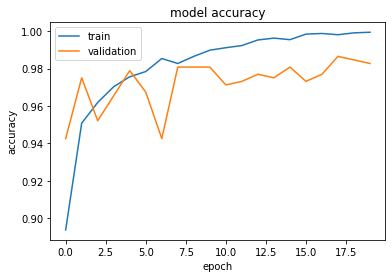

[0.90124273, 0.9516156, 0.9630489, 0.97083676, 0.9764706, 0.9809445, 0.9879039, 0.985087, 0.9879039, 0.9918807, 0.9922121, 0.995029, 0.9965203, 0.9973488, 0.9985087, 0.9988401, 0.9991715, 0.9998343, 0.9991715, 0.9996686]
[0.938697338104248, 0.977011501789093, 0.959770143032074, 0.9578543901443481, 0.9808428883552551, 0.977011501789093, 0.959770143032074, 0.975095808506012, 0.9865900278091431, 0.967432975769043, 0.9789271950721741, 0.9731800556182861, 0.9712643623352051, 0.9731800556182861, 0.975095808506012, 0.9712643623352051, 0.9712643623352051, 0.984674334526062, 0.984674334526062, 0.9712643623352051]


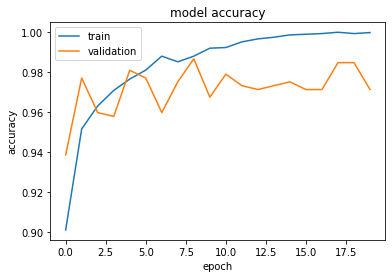

[0.90124273, 0.9516156, 0.9630489, 0.97083676, 0.9764706, 0.9809445, 0.9879039, 0.985087, 0.9879039, 0.9918807, 0.9922121, 0.995029, 0.9965203, 0.9973488, 0.9985087, 0.9988401, 0.9991715, 0.9998343, 0.9991715, 0.9996686]
[0.938697338104248, 0.977011501789093, 0.959770143032074, 0.9578543901443481, 0.9808428883552551, 0.977011501789093, 0.959770143032074, 0.975095808506012, 0.9865900278091431, 0.967432975769043, 0.9789271950721741, 0.9731800556182861, 0.9712643623352051, 0.9731800556182861, 0.975095808506012, 0.9712643623352051, 0.9712643623352051, 0.984674334526062, 0.984674334526062, 0.9712643623352051]


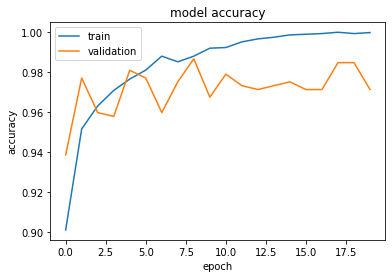

[0.90389395, 0.9545982, 0.9637117, 0.97050536, 0.9749793, 0.981773, 0.9885667, 0.98309857, 0.9888981, 0.9913836, 0.993372, 0.99420047, 0.9965203, 0.9980116, 0.9985087, 0.9993372, 0.9995029, 1.0, 0.9991715, 1.0]
[0.9348658919334412, 0.977011501789093, 0.9655172228813171, 0.967432975769043, 0.9789271950721741, 0.977011501789093, 0.9559386968612671, 0.977011501789093, 0.984674334526062, 0.9731800556182861, 0.977011501789093, 0.9712643623352051, 0.9731800556182861, 0.9731800556182861, 0.982758641242981, 0.975095808506012, 0.969348669052124, 0.982758641242981, 0.984674334526062, 0.9731800556182861]


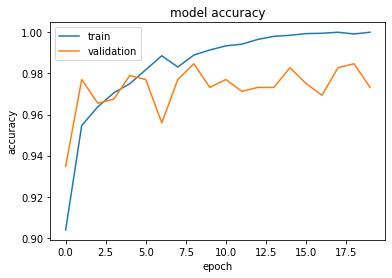

[0.90124273, 0.9516156, 0.9630489, 0.97083676, 0.9764706, 0.9809445, 0.9879039, 0.985087, 0.9879039, 0.9918807, 0.9922121, 0.995029, 0.9965203, 0.9973488, 0.9985087, 0.9988401, 0.9991715, 0.9998343, 0.9991715, 0.9996686]
[0.938697338104248, 0.977011501789093, 0.959770143032074, 0.9578543901443481, 0.9808428883552551, 0.977011501789093, 0.959770143032074, 0.975095808506012, 0.9865900278091431, 0.967432975769043, 0.9789271950721741, 0.9731800556182861, 0.9712643623352051, 0.9731800556182861, 0.975095808506012, 0.9712643623352051, 0.9712643623352051, 0.984674334526062, 0.984674334526062, 0.9712643623352051]


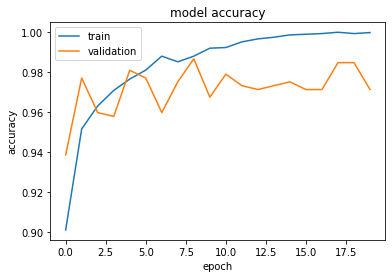

In [20]:

import matplotlib.pyplot as plt
count = 0; 


for i in history_array:
    print(i.history['accuracy'])
    plt.plot(i.history['accuracy'])
    print(i.history['val_accuracy'])
    plt.plot(i.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    name = 'train_vs_validation_accuracy' + str(count) + '.png'
    #plt.savefig('experiment2/'+name)
    plt.show()



[0.2575530577738026, 0.13884058502481905, 0.11521869664757135, 0.0907834963356056, 0.07621035376299781, 0.06332224818577722, 0.0516383934665746, 0.050898561274668304, 0.04114748768488373, 0.03401621519506916, 0.030320604817437157, 0.024881014377094786, 0.02007190621432531, 0.018130858421214573, 0.01807314940275317, 0.011654457952109626, 0.010407706474315903, 0.009431720399486816, 0.008097091329676757, 0.00647106703275131]
[0.16611348908979773, 0.0716283360203564, 0.13813021710549278, 0.09546213805447136, 0.04782340284508307, 0.08116887938017132, 0.1781207405287644, 0.04050614624872975, 0.03750339116173229, 0.05228915136892677, 0.07410891382630301, 0.06218218609291018, 0.05462533914951529, 0.05969886681585933, 0.054053852612944854, 0.06235324879715726, 0.050086433774438395, 0.030627286168693126, 0.033496858173859986, 0.049886096397350574]


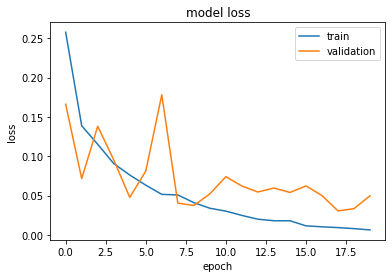

[0.2440814691172124, 0.13424886897910007, 0.10593010830726125, 0.08605477094600886, 0.07304242245587517, 0.05812182095096244, 0.04256066745791396, 0.04592674571153489, 0.036111758320029844, 0.02809501439147778, 0.025555079332039734, 0.019603469326641556, 0.015412826004631773, 0.012741170090090024, 0.010635126286279642, 0.009106118631238225, 0.008551666864742584, 0.006143033817524666, 0.006320490143875273, 0.005317959207316124]
[0.1580261132497897, 0.06290380856543208, 0.10867368512683445, 0.11005801784581151, 0.050500512579848486, 0.05792447844684352, 0.1145836983832363, 0.04601122067805908, 0.034286351296408425, 0.07704758518500346, 0.05588698889560626, 0.06963934912078681, 0.07206705218302335, 0.0666515062709421, 0.06120024221838662, 0.07766724021041987, 0.07747778193704014, 0.0495872064511438, 0.03120368782616438, 0.0765004006153779]


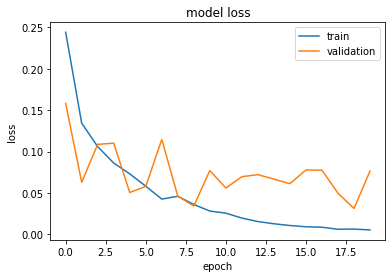

[0.24408147094189478, 0.13424886605565767, 0.10593010805541064, 0.08605477082008356, 0.07304242301883536, 0.058121820895407156, 0.04256066785791199, 0.045926741395506766, 0.036111756008930115, 0.02809501403438077, 0.02555508094190835, 0.01960347020318045, 0.015412826836417802, 0.012741172408288485, 0.01063512543196286, 0.009106117411491144, 0.008551658288241606, 0.0061430331030991716, 0.0063204895782144775, 0.005317954760424441]
[0.1580260925822788, 0.06290380308454521, 0.10867368113035443, 0.11005801145144349, 0.05050051246566334, 0.05792448883769156, 0.11458368673635169, 0.04601122889938939, 0.034286340734282675, 0.07704757205371199, 0.05588698272960853, 0.06963935277471141, 0.07206708238499375, 0.06665149679357521, 0.06120024381697863, 0.0776673063236178, 0.07747780157688477, 0.04958717858996885, 0.031203696675512982, 0.07650038679897557]


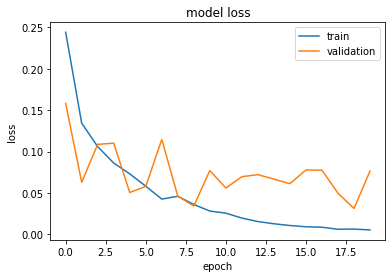

[0.23932941253138854, 0.13177429038750404, 0.10482845061274235, 0.08445424975544931, 0.07383216362579262, 0.05630329955236519, 0.04341246120549905, 0.045859791108043654, 0.03587599345540756, 0.027905967557538908, 0.023303734082281095, 0.020767890901459873, 0.01491135071034064, 0.011690658454219221, 0.010419252131662046, 0.008368663309804028, 0.008160395087796174, 0.005862637556465875, 0.005871178031541783, 0.00458327185458256]
[0.16549960852126053, 0.062452205867146164, 0.09048831211652793, 0.10085983180451667, 0.05395152902237757, 0.06614912378376928, 0.13397660748711948, 0.04259170791655208, 0.03408733315737311, 0.06821736476430491, 0.0672713715682998, 0.07241577663640866, 0.07451517879962921, 0.06346867373391586, 0.05420609492223381, 0.06798970722147331, 0.08846878434506412, 0.05109354354070064, 0.034805022808098704, 0.07239357213636011]


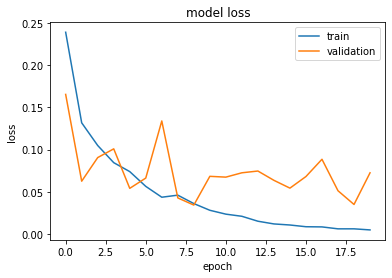

[0.24408146978140668, 0.13424886848897902, 0.105930108671457, 0.08605477266204979, 0.07304242028736732, 0.05812182140404663, 0.0425606663764378, 0.04592674595844726, 0.03611175791509357, 0.028095016525417887, 0.025555080146078938, 0.019603468413374448, 0.01541282626635888, 0.012741170132065126, 0.010635124844311433, 0.009106119960321186, 0.008551660184528565, 0.0061430341870444514, 0.0063204891364728255, 0.005317958599294427]
[0.15802612329808233, 0.06290380559661836, 0.10867368387079787, 0.1100580257245864, 0.05050051280821877, 0.057924483528082396, 0.11458370649038147, 0.046011219764577935, 0.03428634658627126, 0.07704758096015317, 0.05588698689736626, 0.06963936179533772, 0.07206706856859141, 0.06665149907727808, 0.06120025866104725, 0.07766729536184407, 0.07747780688649393, 0.04958717801904313, 0.031203684172239798, 0.07650039102382587]


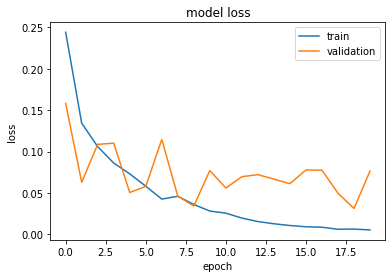

In [21]:

count = 0 
for i in history_array:
    print(i.history['loss'])
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    print(i.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    name = 'train_vs_test_loss_shuffled_btch32_' + str(count) + '.png'
    #plt.savefig(name)
    count = count +1
    plt.show()    
    
  

In [22]:
from sklearn.metrics import confusion_matrix
def classification_report():
    
    for i in model_array:
        y_pred = i.predict_classes(X_test)
        matrix = ["TN","FP"],["FN","TP"]
        print(matrix[0])
        print(matrix[1])

        ##Lets Visualise the output
        conf=confusion_matrix(Y_test, y_pred)
        print("Confusion Matrix")
        print(conf)
        # or we can use a heatmap from the seaborn library
        #import seaborn as sn
        #df_cm = pandas.DataFrame(conf, range(2), range(2))
        #sn.set(font_scale=1.4)#for label size
        #sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

        from sklearn.metrics import classification_report
        print(classification_report(Y_test,y_pred));
        



In [23]:
classification_report()

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[180  54]
 [  4 386]]
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86       234
         1.0       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.90       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[195  39]
 [  4 386]]
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90       234
         1.0       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.94      0.93      0.93       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[195  39]
 [  4 386]]
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90       234
         1.0       0.91      0.99      